In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

In [3]:
# Reading the training data
dtrain = pd.read_csv('train.csv')

## Missing Data
# Calculate percentage of missing data for each column
miss_pct = (dtrain.isnull().sum() / len(dtrain)) * 100
miss_pct = miss_pct[miss_pct > 0].sort_values(ascending=False)


In [4]:
dtrain.shape

(30471, 292)

In [13]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_correlations(df, threshold):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print(au_corr)
    return au_corr[au_corr['price_doc'] > threshold]

def get_categorical_columns(df):
    cols = []
    for c in df.columns:
        if df[c].dtype=='object':
            cols.append(c)

    return cols

In [8]:
missing_data = miss_pct.keys().values.tolist()
missing_data.append('price_doc')

# Find correlation of columns that have lots of missing data to target label
# filter out those that have low correlation (below 0.1)
missing_corr_matrix = dtrain[missing_data].corr()
missing_corr_matrix = missing_corr_matrix[missing_corr_matrix['price_doc'] < 0.1]['price_doc']
missing_corr_matrix = missing_corr_matrix[:len(missing_corr_matrix) - 1]
col_to_remove = missing_corr_matrix.keys().values.tolist()



In [12]:
missing_corr_matrix = dtrain[missing_data].corr()
low_miss_corr = missing_corr_matrix[abs(missing_corr_matrix['price_doc']) < 0.01]['price_doc']
print(low_miss_corr)

build_year                     0.002161
build_count_1971-1995         -0.009734
cafe_avg_price_3000            0.003339
cafe_sum_3000_max_price_avg    0.002200
cafe_sum_3000_min_price_avg    0.005119
Name: price_doc, dtype: float64


In [17]:
dtrain_1 = dtrain.copy()
cat_cols = get_categorical_columns(dtrain_1)
dtrain_1.drop(cat_cols, axis=1, inplace=True)
corr_matrix = dtrain_1.corr()
low_corr = corr_matrix[abs(corr_matrix['price_doc']) < 0.01]['price_doc']
print(low_corr)

build_year                     0.002161
build_count_1971-1995         -0.009734
prom_part_500                 -0.009009
trc_sqm_500                    0.000374
cafe_sum_3000_min_price_avg    0.005119
cafe_sum_3000_max_price_avg    0.002200
cafe_avg_price_3000            0.003339
Name: price_doc, dtype: float64


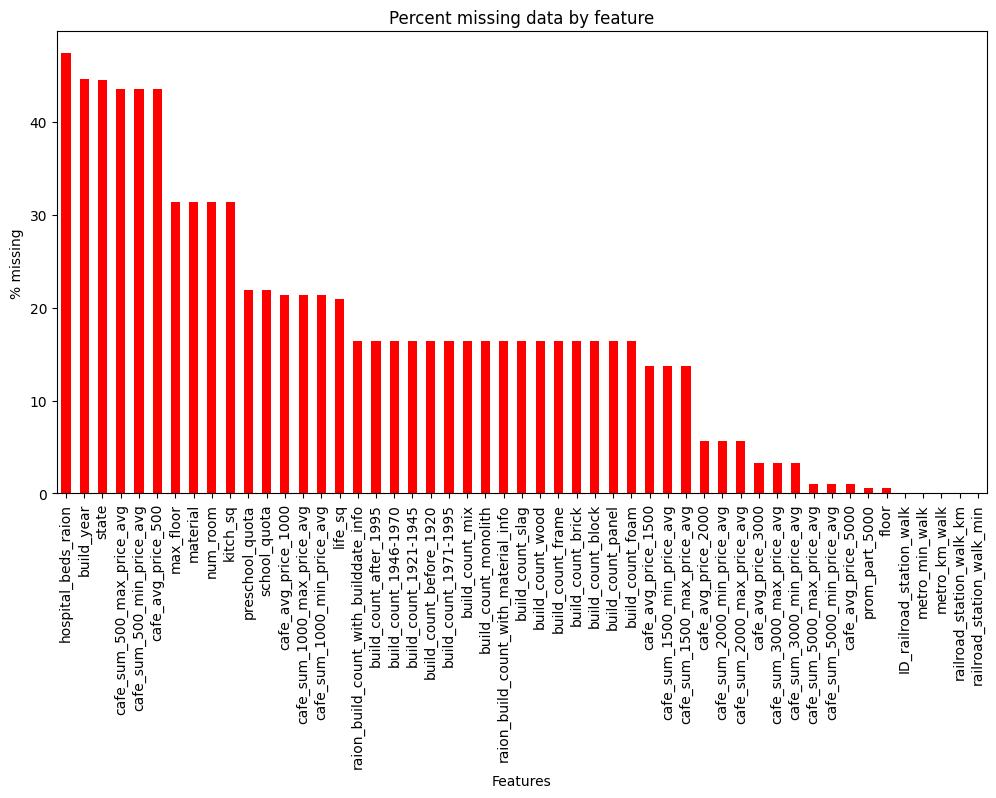

In [3]:
# Plotting missing data
plt.figure(figsize=(12, 6))
miss_pct.plot(kind='bar', color='red')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('% missing')
plt.title('Percent missing data by feature')
plt.show()

In [4]:
print(f"Of {len(dtrain.columns)} columns, {len(miss_pct)} have missing values.")
print(f"The percentage of values missing ranges from {miss_pct.min():.1f}% in {miss_pct.idxmin()} to {miss_pct.max():.1f}% in {miss_pct.idxmax()}.")

## Data Quality Issues
# Fixing data quality issues in train.csv

# state should be discrete valued between 1 and 4. There is a 33 in it that is clearly a data entry error
# Let's replace it with the mode.
dtrain['state'] = dtrain['state'].replace(33, dtrain['state'].mode()[0])

# build_year has an erroneous value 20052009. Since it's unclear which it should be, let's replace it with 2007
dtrain['build_year'] = dtrain['build_year'].replace(20052009, 2007)

Of 292 columns, 51 have missing values.
The percentage of values missing ranges from 0.1% in ID_railroad_station_walk to 47.4% in hospital_beds_raion.


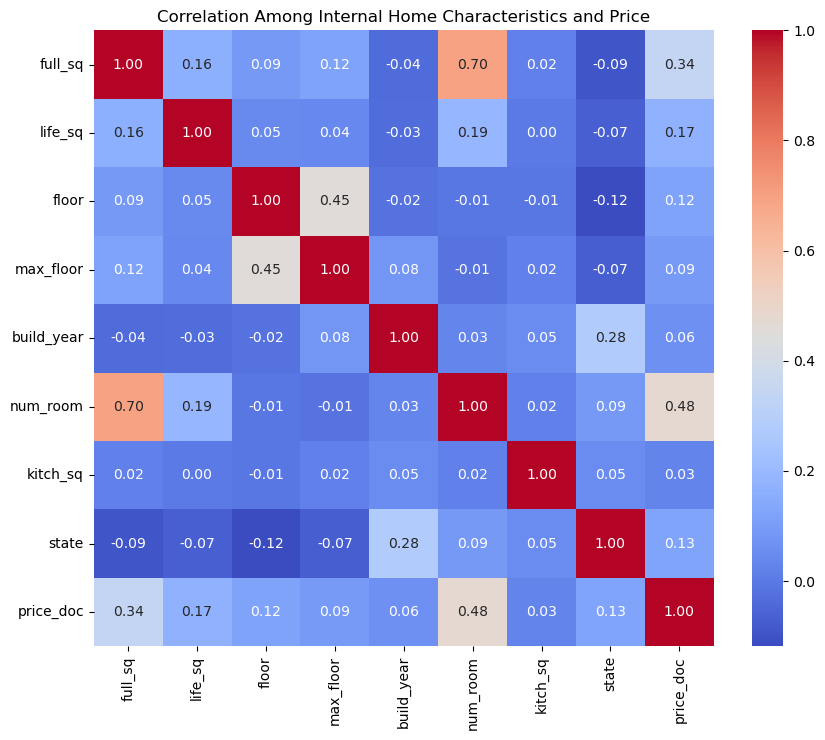

In [5]:
# Housing Internal Characteristics {#internal}

# Correlation among internal home characteristics and price
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
correlation_matrix = dtrain[internal_chars].corr()

# Plotting correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Among Internal Home Characteristics and Price")
plt.show()


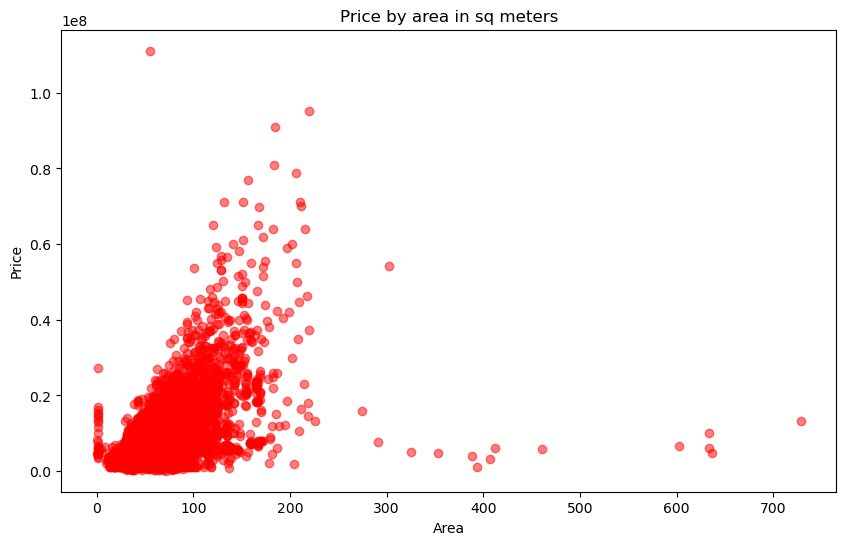

In [6]:
# Area of Home and Number of Rooms

# Removing outliers in full_sq
dtrain = dtrain[dtrain['full_sq'] < 2000]

# Plotting price by area in sq meters
plt.figure(figsize=(10, 6))
plt.scatter(dtrain['full_sq'], dtrain['price_doc'], color='red', alpha=0.5)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Price by area in sq meters')
plt.show()


 ### The feature full_sq is defined in the data dictionary as 'total area in square meters, including loggias, balconies and other non-residential areas' and the life_sq is defined as 'living area in square meters, excluding loggias, balconies and other non-residential areas.' So it should be the case that life_sq is always less than full_sq.

In [7]:
# Checking for life_sq greater than full_sq
invalid_life_sq = sum(dtrain['life_sq'] > dtrain['full_sq'].dropna())

print(f"There are {invalid_life_sq} observations where life_sq is greater than full_sq.")

There are 37 observations where life_sq is greater than full_sq.


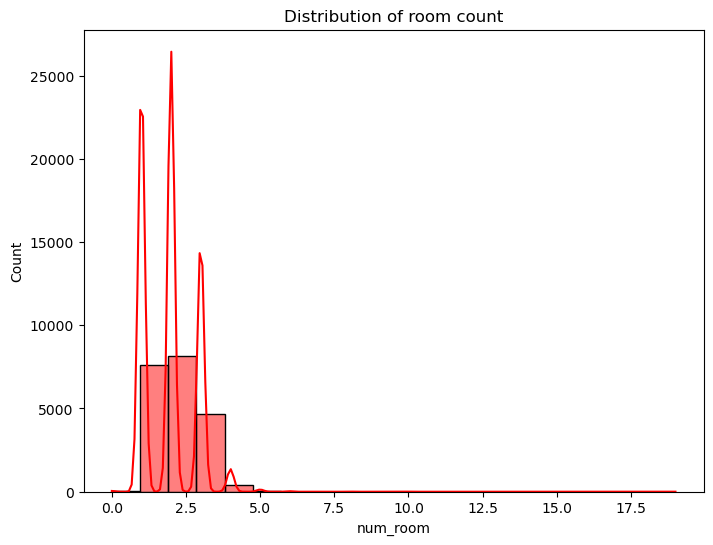

In [8]:
# Plotting distribution of room count
plt.figure(figsize=(8, 6))
sns.histplot(dtrain['num_room'], bins=20, color='red', kde=True)
plt.title('Distribution of room count')
plt.show()

### A vast majority of the apartments have three rooms or less. 

### Is there a significant difference in price for homes bought by an owner-occupier or homes bought for investment?


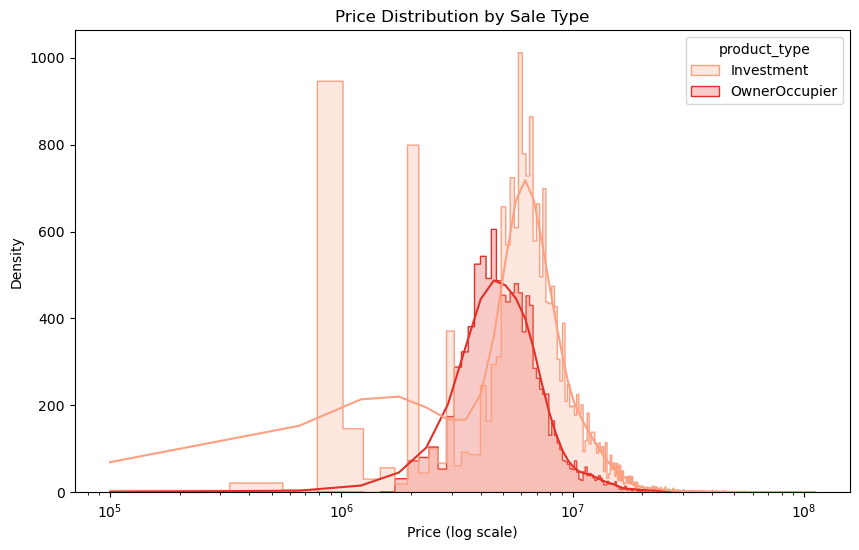

product_type
Investment       6670000.0
OwnerOccupier    5562580.0
Name: price_doc, dtype: float64


In [9]:
# Sale Type
plt.figure(figsize=(10, 6))
sns.histplot(data=dtrain, x='price_doc', hue='product_type', kde=True, common_norm=False, element="step", fill=True, palette='Reds')
plt.xscale('log')
plt.title('Price Distribution by Sale Type')
plt.xlabel('Price (log scale)')
plt.ylabel('Density')
plt.show()

median_prices_by_type = dtrain.groupby('product_type')['price_doc'].median()
print(median_prices_by_type)


### It's not clear from the density plots, but homes sold for investment sell for more than homes sold to owner-occupiers.


### There are a number of nonsensical years - 0, 1, 3, 20, 71, 215, 2018, and 4965. The 1691 I guess is possible. In another kernel, I plan on setting these to NA and using the mice package to impute these values. For now, let's limit our visualizations to the reasonable years:


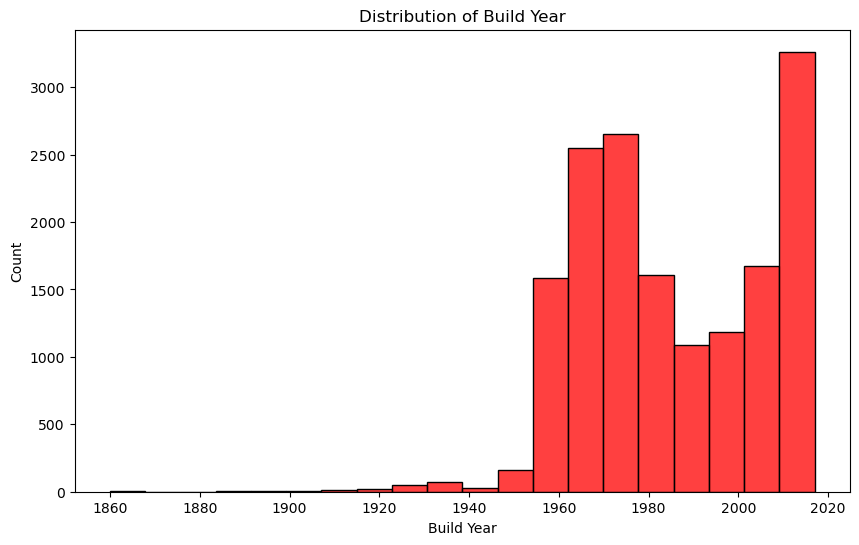

In [10]:
# Build Year
dtrain = dtrain[(dtrain['build_year'] > 1691) & (dtrain['build_year'] < 2018)]

plt.figure(figsize=(10, 6))
sns.histplot(data=dtrain, x='build_year', bins=20, color='red')
plt.title('Distribution of Build Year')
plt.xlabel('Build Year')
plt.ylabel('Count')
plt.show()


### The distribution appears bimodal with a peak somewhere in the early 1970s and somewhere in the past few years. 

### Now let's see if build_year and prices are related. Here I group the data by year and take the mean of price_doc. 


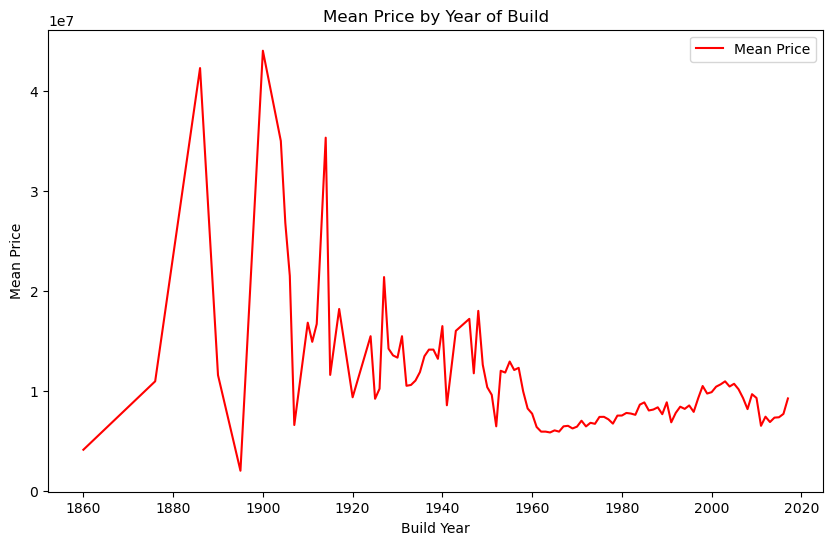

In [11]:
plt.figure(figsize=(10, 6))
mean_prices_by_year = dtrain.groupby('build_year')['price_doc'].mean()
plt.plot(mean_prices_by_year.index, mean_prices_by_year.values, color='red', label='Mean Price')
plt.xlabel('Build Year')
plt.ylabel('Mean Price')
plt.title('Mean Price by Year of Build')
plt.legend()
plt.show()


### The relationship appears somewhat steady over time, especially after 1960. There is some volatility in the earlier years. This is not a real effect but simply due to the sparseness of observations until around 1950.


### How does the sale price vary over the time horizon of the data set? Here I just group by the day and caclulate the median price for each day and plot it over time. 


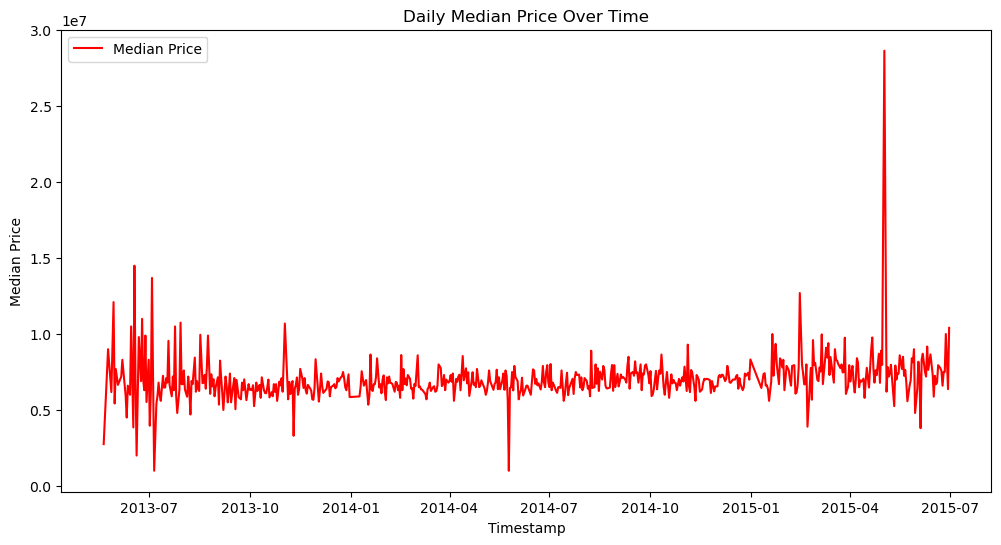

In [12]:
# Timestamp
dtrain['timestamp'] = pd.to_datetime(dtrain['timestamp'])

median_prices_by_day = dtrain.groupby('timestamp')['price_doc'].median()
plt.figure(figsize=(12, 6))
plt.plot(median_prices_by_day.index, median_prices_by_day.values, color='red', label='Median Price')
plt.xlabel('Timestamp')
plt.ylabel('Median Price')
plt.title('Daily Median Price Over Time')
plt.legend()
plt.show()


### And to compare with the above plot, here is the volume of sales over the same time.


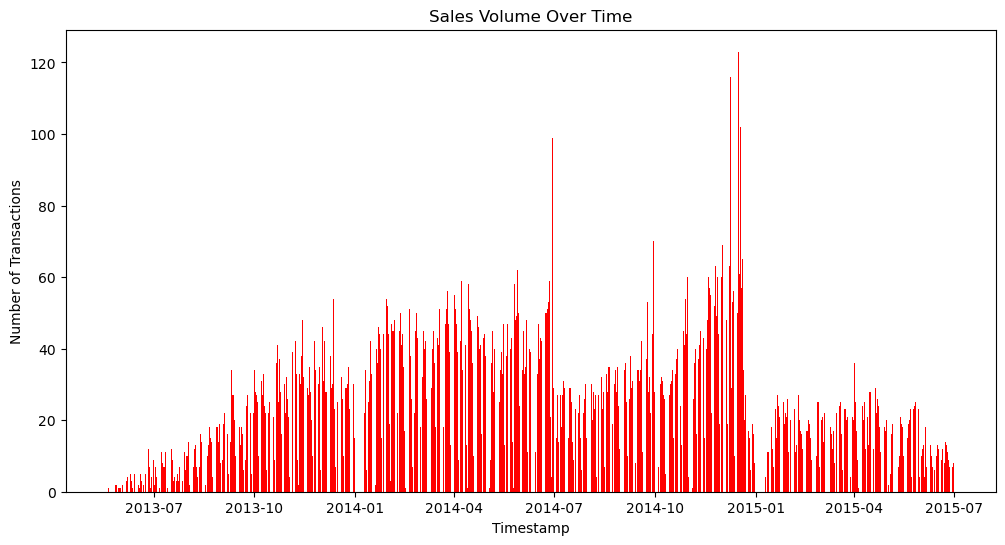

In [13]:
sales_count_by_day = dtrain.groupby('timestamp').size()
plt.figure(figsize=(12, 6))
plt.bar(sales_count_by_day.index, sales_count_by_day.values, color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Sales Volume Over Time')
plt.show()


### Is there a seasonal component to home prices in the course of a year?


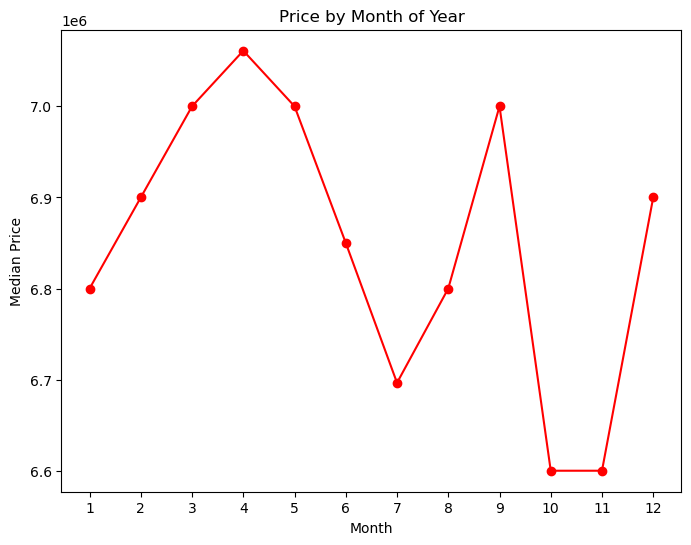

In [14]:
# Seasonal Component
dtrain['month'] = dtrain['timestamp'].dt.month

median_prices_by_month = dtrain.groupby('month')['price_doc'].median()
plt.figure(figsize=(8, 6))
plt.plot(median_prices_by_month.index, median_prices_by_month.values, color='red', marker='o')
plt.xlabel('Month')
plt.ylabel('Median Price')
plt.title('Price by Month of Year')
plt.xticks(range(1, 13))
plt.show()


### How do homes vary in price by condition?


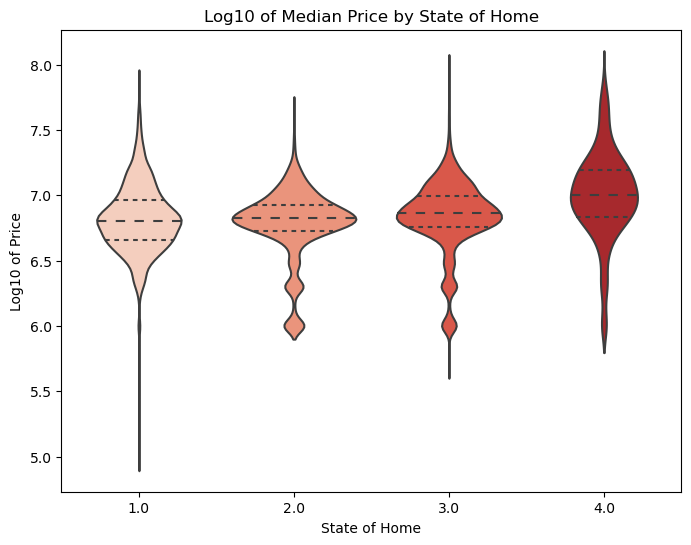

In [15]:
# Home State/Material
plt.figure(figsize=(8, 6))
sns.violinplot(x='state', y=np.log10(dtrain['price_doc']), data=dtrain.dropna(subset=['state']), inner='quartile', palette='Reds')
plt.title('Log10 of Median Price by State of Home')
plt.xlabel('State of Home')
plt.ylabel('Log10 of Price')
plt.show()

### It's hard to tell from the plot, but it does appear that state 4 has the highest sale price on average. Significantly fewer homes fall under this category however. Let's check:


In [16]:
median_prices_by_state = dtrain.groupby('state')['price_doc'].median()
print(median_prices_by_state)

state
1.0     6400000.0
2.0     6650000.0
3.0     7272500.0
4.0    10025000.0
Name: price_doc, dtype: float64


### State 4 has the highest average price by far, followed by state 3. State 1 and 2 are close. 


### What about the material feature? 

In [17]:
materials = dtrain['material'].value_counts()
print(materials)

1.0    10024
2.0     2846
5.0     1533
4.0      987
6.0      570
Name: material, dtype: int64


### It's unclear what these values mean since this feature is not described in the data dictionary. Material 1 is by far the most common. Only one home is classifed as material 3. How does median price compare among these six materials?


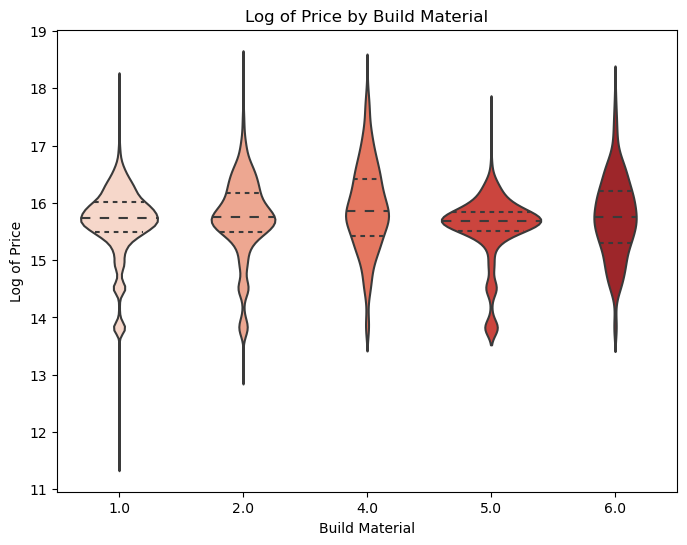

In [18]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='material', y=np.log(dtrain['price_doc']), data=dtrain.dropna(subset=['material']), inner='quartile', palette='Reds')
plt.title('Log of Price by Build Material')
plt.xlabel('Build Material')
plt.ylabel('Log of Price')
plt.show()

### Using a log scale for the price makes this plot a lot more informative, but what about the raw prices?


In [19]:
median_prices_by_material = dtrain.groupby('material')['price_doc'].median()
print(median_prices_by_material)

material
1.0    6862500.0
2.0    7000000.0
4.0    7754600.0
5.0    6485368.0
6.0    6884736.0
Name: price_doc, dtype: float64


### How does the floor feature compare with price? According to the correlation plot from earlier, there is a moderate positive correlation. 


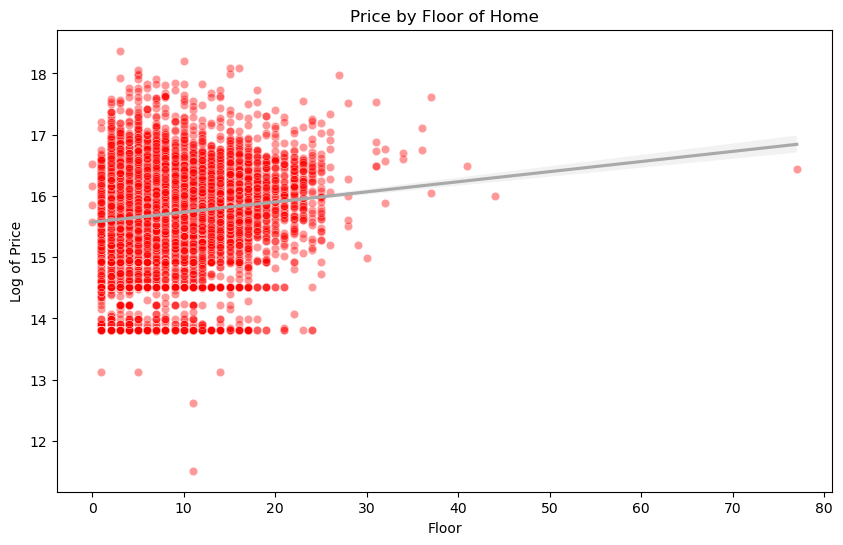

In [20]:
# Floor of Home
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor', y=np.log(dtrain['price_doc']), data=dtrain, color='red', alpha=0.4)
sns.regplot(x='floor', y=np.log(dtrain['price_doc']), data=dtrain, scatter=False, color='darkgrey')
plt.title('Price by Floor of Home')
plt.xlabel('Floor')
plt.ylabel('Log of Price')
plt.show()

### On a whole, price seems to rise with the floor, although the effect is pretty small. Along the same lines, I wonder if the height of building is correlated with price. Well look at this using max_floor as a proxy for height. 


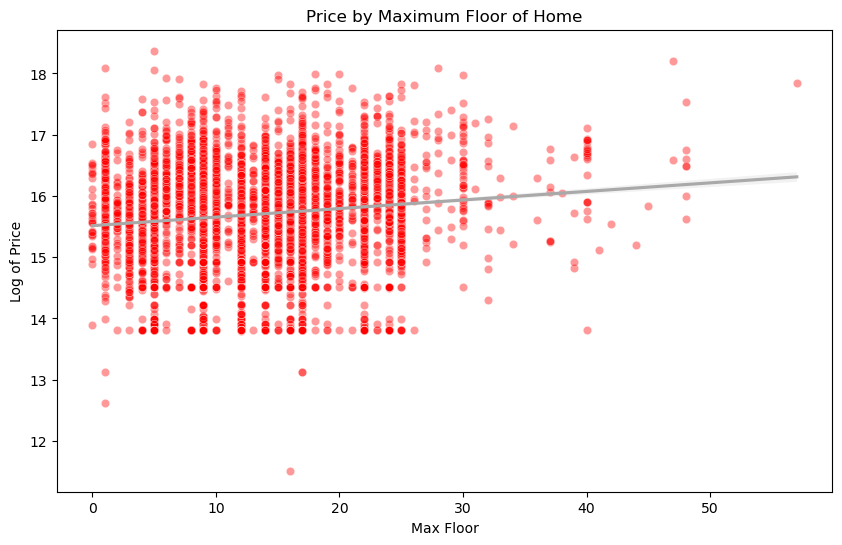

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='max_floor', y=np.log(dtrain['price_doc']), data=dtrain, color='red', alpha=0.4)
sns.regplot(x='max_floor', y=np.log(dtrain['price_doc']), data=dtrain, scatter=False, color='darkgrey')
plt.title('Price by Maximum Floor of Home')
plt.xlabel('Max Floor')
plt.ylabel('Log of Price')
plt.show()


### Again a small positive correlation. This effect however is likely being confounded by the fact that the urban core has both more expensive real estate and taller buildings. So the height of the building alone is likely not what is determing price here. 


### Let's check the quality of the data and see if floor is greater than max_floor for any observations:


In [22]:
invalid_floor_max_floor = dtrain[dtrain['floor'] > dtrain['max_floor']]
print(invalid_floor_max_floor[['id', 'floor', 'max_floor']])

print(f"There are {len(invalid_floor_max_floor)} observations where floor is greater than max_floor.")



          id  floor  max_floor
8268    8271    3.0        1.0
8499    8502    2.0        0.0
8912    8915    5.0        0.0
9161    9164    8.0        3.0
9257    9260    8.0        1.0
...      ...    ...        ...
30244  30247    2.0        1.0
30257  30260    7.0        2.0
30273  30276   12.0        0.0
30317  30320    8.0        1.0
30341  30344   22.0        1.0

[381 rows x 3 columns]
There are 381 observations where floor is greater than max_floor.


In [23]:
dtrain = dtrain.loc[dtrain['floor'] < dtrain['max_floor']]

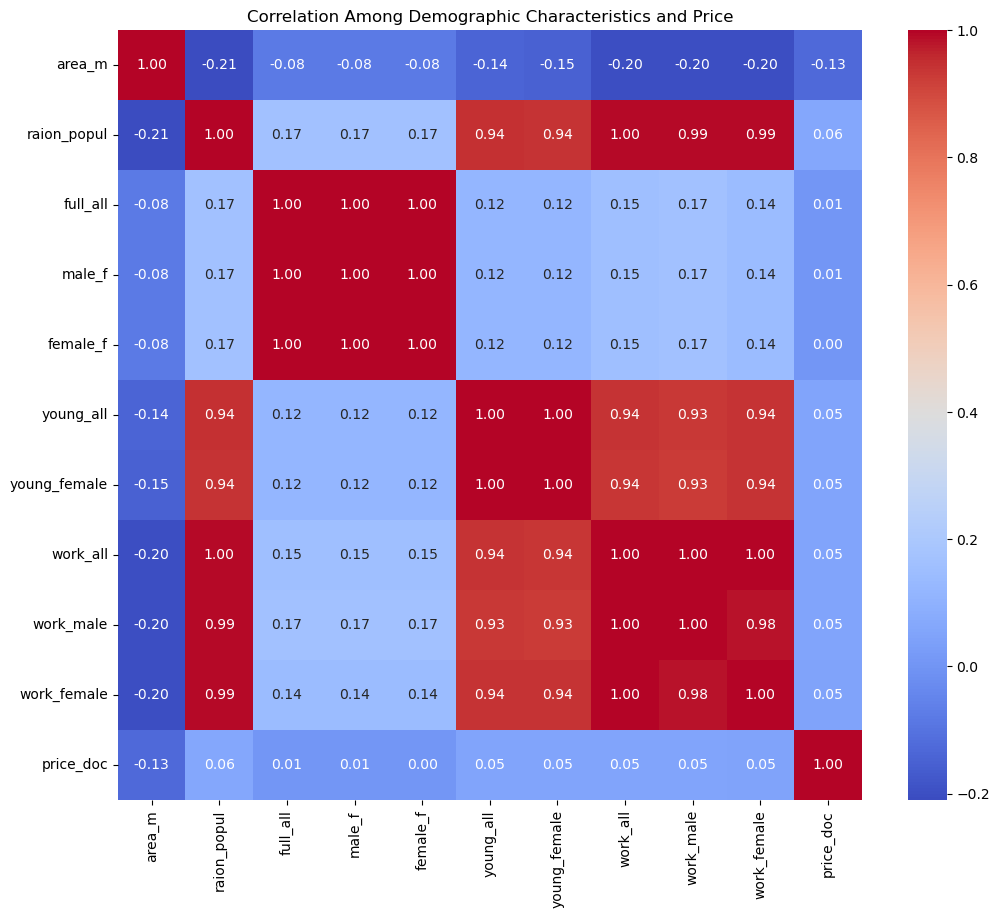

In [24]:
# Demographic Characteristics
demo_vars = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 
             'young_female', 'work_all', 'work_male', 'work_female', 'price_doc']

plt.figure(figsize=(12, 10))
sns.heatmap(dtrain[demo_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Among Demographic Characteristics and Price")
plt.show()



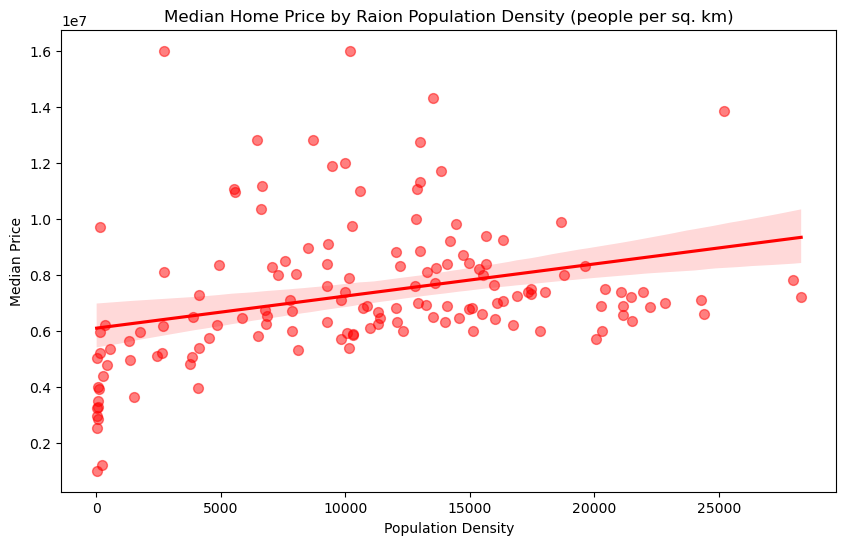

In [25]:
# Population Density
dtrain['area_km'] = dtrain['area_m'] / 1000000
dtrain['density'] = dtrain['raion_popul'] / dtrain['area_km']
density_price_data = dtrain.groupby('sub_area').agg({'density': 'median', 'price_doc': 'median'})
plt.figure(figsize=(10, 6))
sns.regplot(x='density', y='price_doc', data=density_price_data, color='red', scatter_kws={'s': 50, 'alpha':0.5})
plt.title('Median Home Price by Raion Population Density (people per sq. km)')
plt.xlabel('Population Density')
plt.ylabel('Median Price')
plt.show()


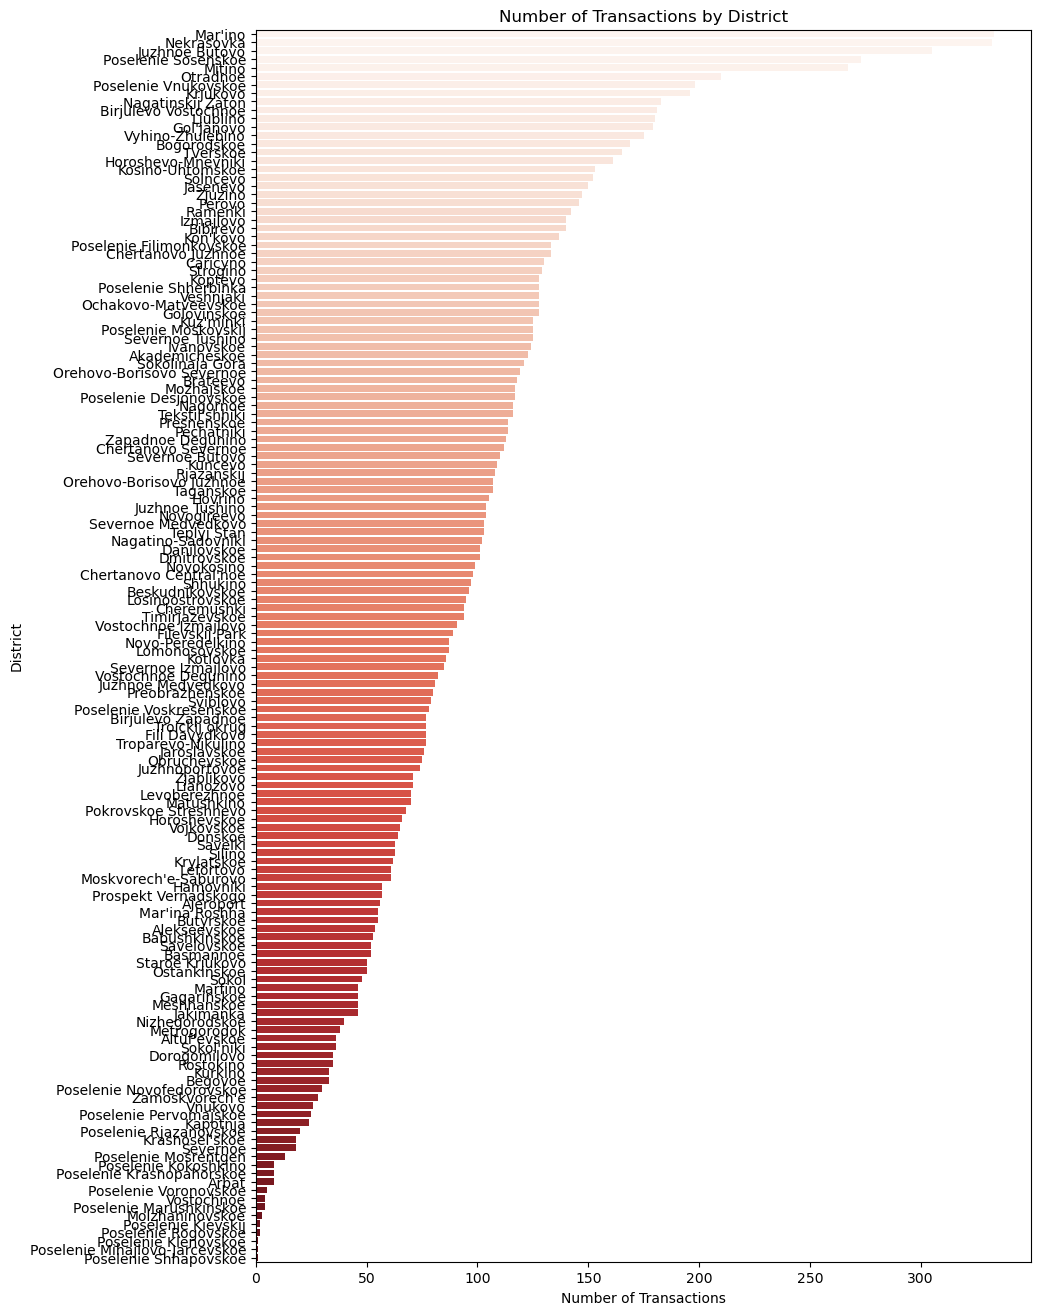

In [26]:
# Number of Transactions by District
plt.figure(figsize=(10, 16))
sns.barplot(y=dtrain['sub_area'].value_counts().index, x=dtrain['sub_area'].value_counts().values, palette='Reds')
plt.title('Number of Transactions by District')
plt.xlabel('Number of Transactions')
plt.ylabel('District')
plt.show()

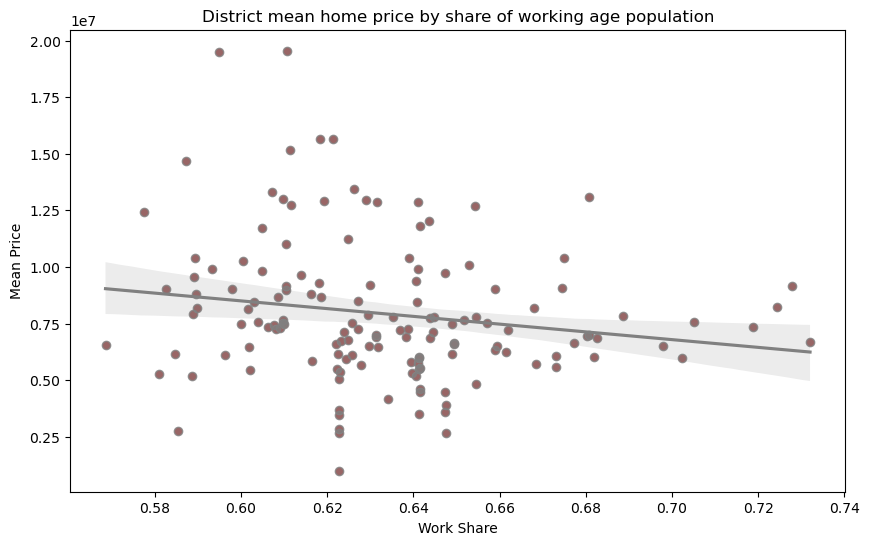

In [27]:
dtrain['work_share'] = dtrain['work_all'] / dtrain['raion_popul']
mean_price_per_work_share = dtrain.groupby('work_share')['price_doc'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_price_per_work_share, x='work_share', y='price_doc', color='red')

# Add a regression line
sns.regplot(data=mean_price_per_work_share, x='work_share', y='price_doc', color='gray')

# Set labels and title
plt.xlabel('Work Share')
plt.ylabel('Mean Price')
plt.title('District mean home price by share of working age population')


plt.show()

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='work_share', y='mean_price', data=grouped_data, color='red')
# sns.regplot(x='work_share', y='mean_price', data=grouped_data, color='gray', scatter=False)
# plt.title('District mean home price by share of working age population')
# plt.show()

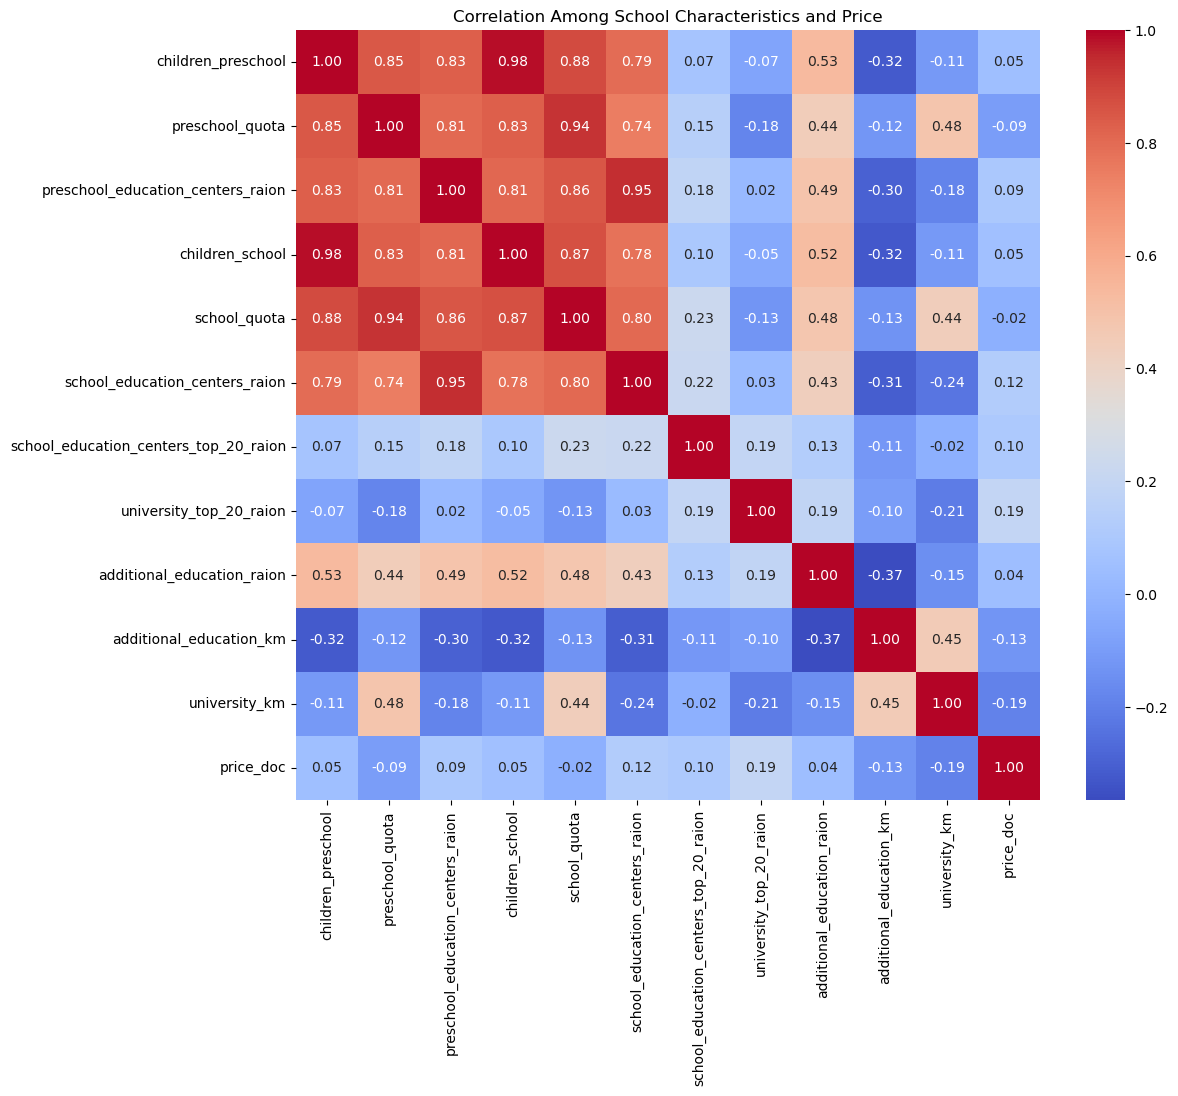

In [28]:
# School Characteristics
school_chars = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion',
                'children_school', 'school_quota', 'school_education_centers_raion', 
                'school_education_centers_top_20_raion', 'university_top_20_raion',
                'additional_education_raion', 'additional_education_km', 'university_km',
                'price_doc']

plt.figure(figsize=(12, 10))
sns.heatmap(dtrain[school_chars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Among School Characteristics and Price")
plt.show()

In [29]:
# University Top 20 Raion
print(dtrain['university_top_20_raion'].value_counts())


0    12063
1     1131
2      364
3       28
Name: university_top_20_raion, dtype: int64


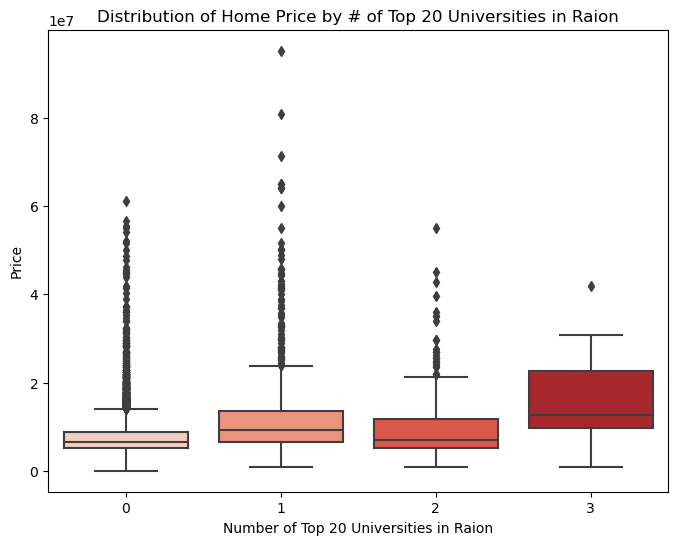

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='university_top_20_raion', y='price_doc', data=dtrain, palette='Reds')
plt.title('Distribution of Home Price by # of Top 20 Universities in Raion')
plt.xlabel('Number of Top 20 Universities in Raion')
plt.ylabel('Price')
plt.show()


In [31]:
top_universities_raion_3 = dtrain[dtrain['university_top_20_raion'] == 3]['sub_area'].unique()
print(f"There is one district with 3 top 20 universities: {top_universities_raion_3}")

# More analyses can be added here


There is one district with 3 top 20 universities: ["Zamoskvorech'e"]


# Cultural recreational Characteristics and price 

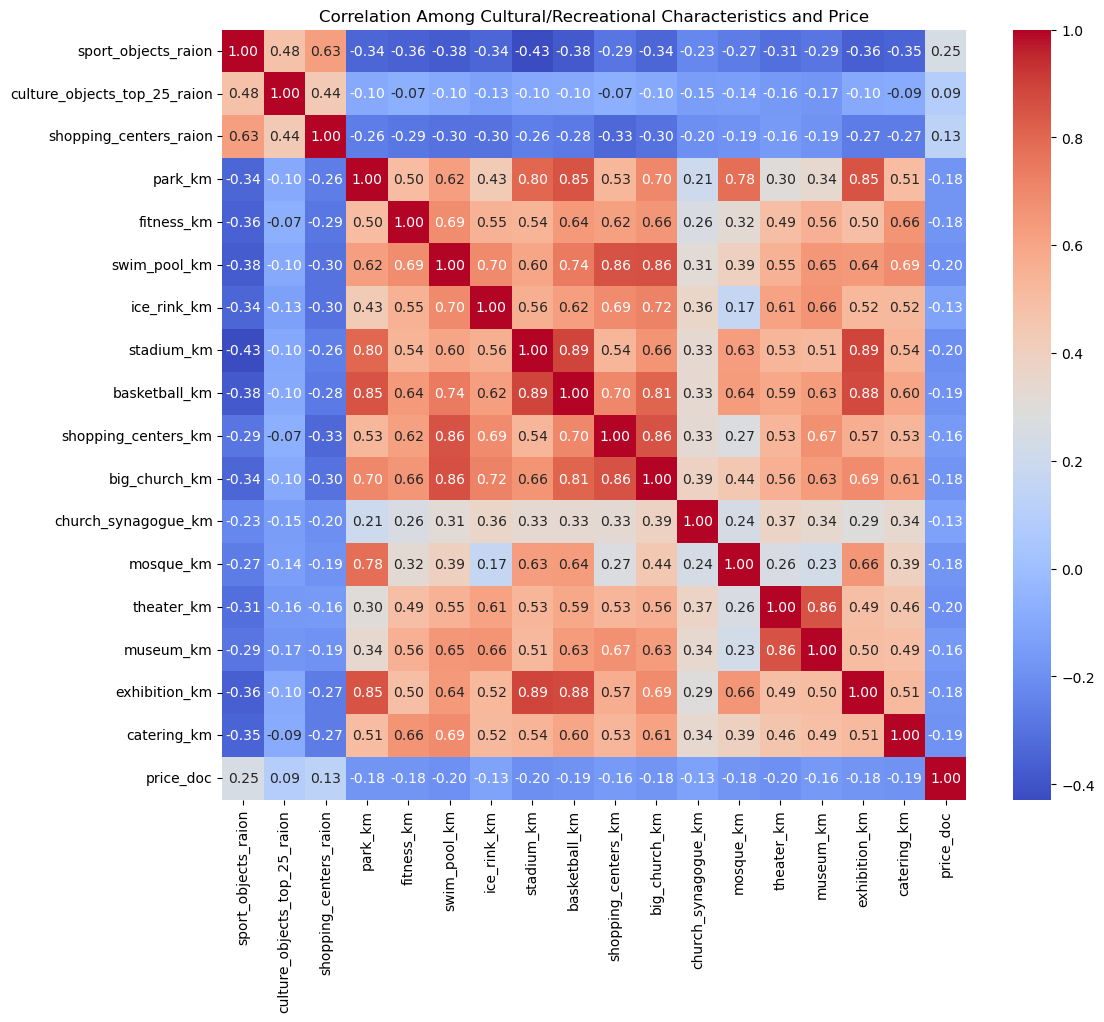

In [32]:
cult_chars = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion',
              'park_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km',
              'shopping_centers_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km',
              'museum_km', 'exhibition_km', 'catering_km', 'price_doc']

# Correlation plot
plt.figure(figsize=(12, 10))
sns.heatmap(dtrain[cult_chars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Among Cultural/Recreational Characteristics and Price")
plt.show()



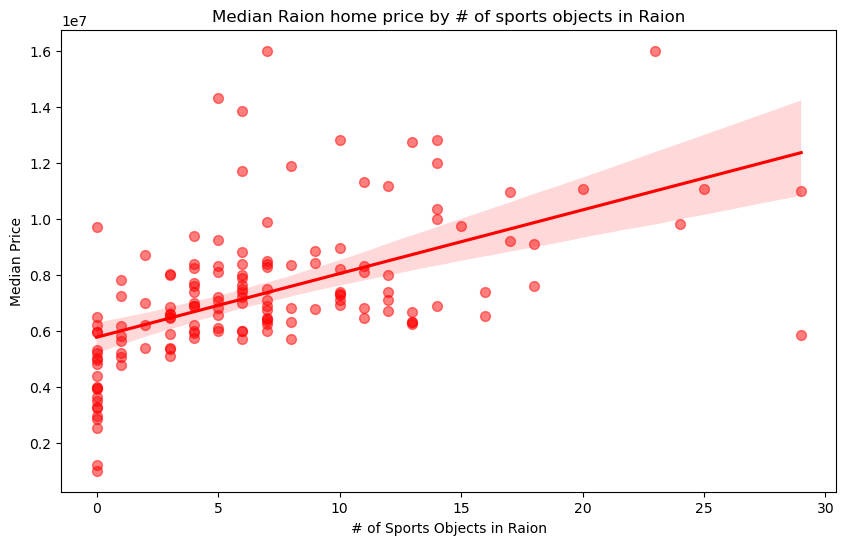

In [33]:
# Median home price by # of sports objects in Raion
sport_objects_price = dtrain.groupby('sub_area').agg({'sport_objects_raion': 'mean', 'price_doc': 'median'})
plt.figure(figsize=(10, 6))
sns.regplot(x='sport_objects_raion', y='price_doc', data=sport_objects_price, color='red', scatter_kws={'s': 50, 'alpha':0.5})
plt.title('Median Raion home price by # of sports objects in Raion')
plt.xlabel('# of Sports Objects in Raion')
plt.ylabel('Median Price')
plt.show()


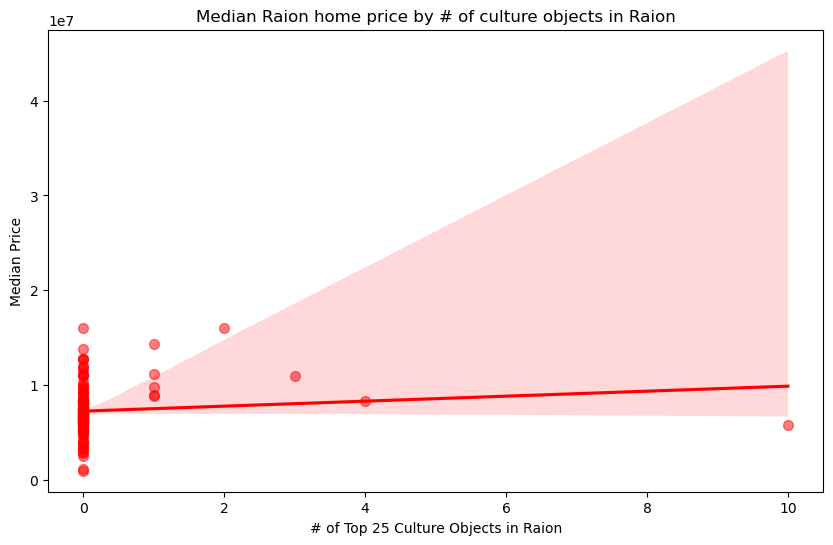

In [34]:
# Median home price by # of culture objects in Raion
culture_objects_price = dtrain.groupby('sub_area').agg({'culture_objects_top_25_raion': 'mean', 'price_doc': 'median'})
plt.figure(figsize=(10, 6))
sns.regplot(x='culture_objects_top_25_raion', y='price_doc', data=culture_objects_price, color='red', scatter_kws={'s': 50, 'alpha':0.5})
plt.title('Median Raion home price by # of culture objects in Raion')
plt.xlabel('# of Top 25 Culture Objects in Raion')
plt.ylabel('Median Price')
plt.show()


In [35]:
# Median home price difference between raions with and without top 25 culture objects
culture_objects_price_diff = dtrain.groupby('culture_objects_top_25').agg({'price_doc': 'median'})
print(culture_objects_price_diff)


                        price_doc
culture_objects_top_25           
no                      6800000.0
yes                     9198628.0


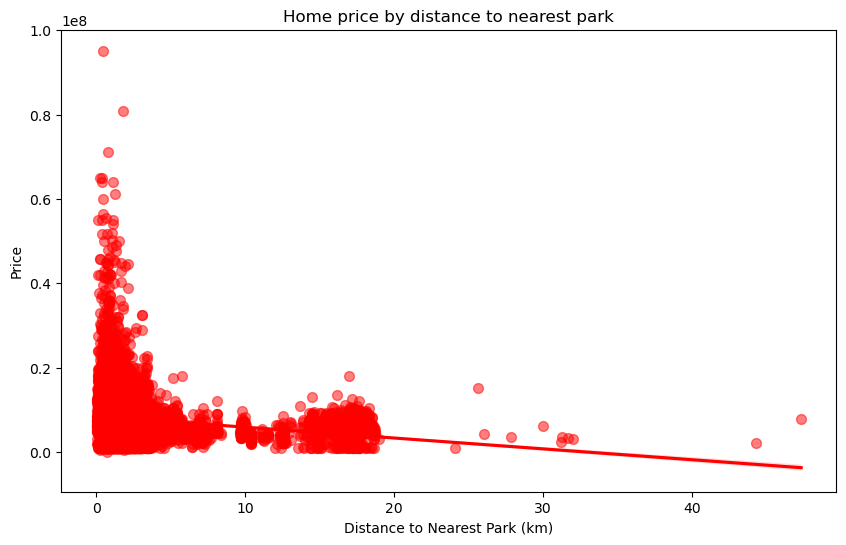

In [36]:
# Home price by distance to nearest park
plt.figure(figsize=(10, 6))
sns.regplot(x='park_km', y='price_doc', data=dtrain, color='red', scatter_kws={'s': 50, 'alpha':0.5})
plt.title('Home price by distance to nearest park')
plt.xlabel('Distance to Nearest Park (km)')
plt.ylabel('Price')
plt.show()

# ... More analysis can be added here ...

# Infrastructure Features (Skipped as it's not provided in the R code)

# Variable Importance (Skipped as it's not provided in the R code)

# Train vs Test Data (Skipped as it's not provided in the R code)

# Infrastructure features with respect to price

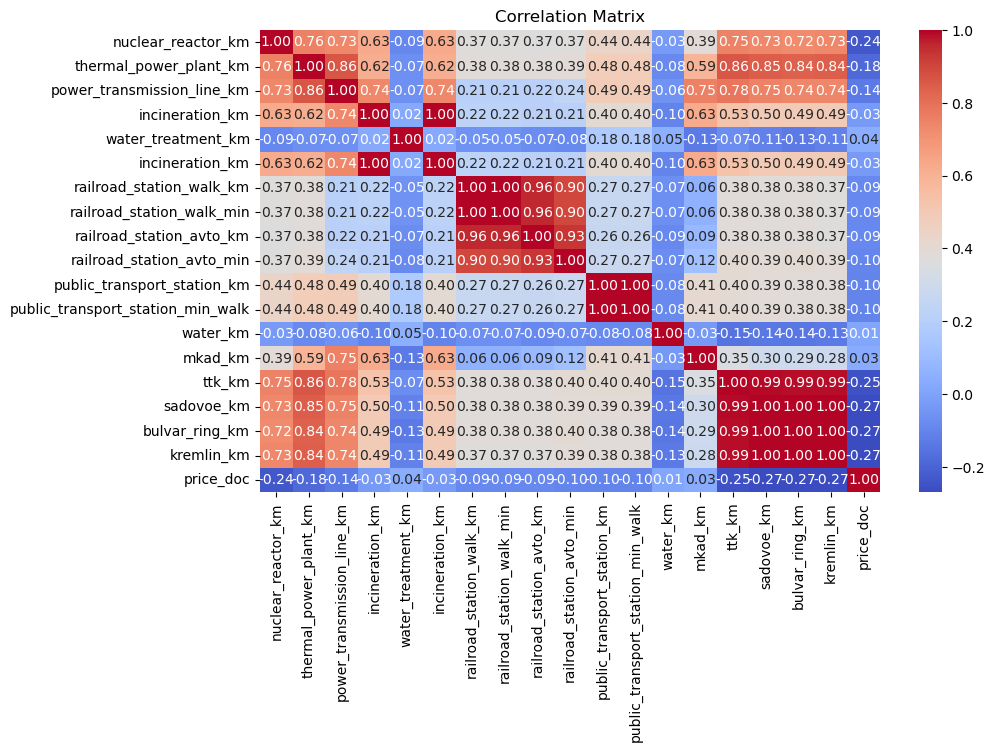

In [37]:
inf_features = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km',
                'incineration_km', 'water_treatment_km', 'incineration_km', 'railroad_station_walk_km',
                'railroad_station_walk_min', 'railroad_station_avto_km', 'railroad_station_avto_min',
                'public_transport_station_km', 'public_transport_station_min_walk', 'water_km',
                'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'price_doc']

correlation_matrix = dtrain[inf_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

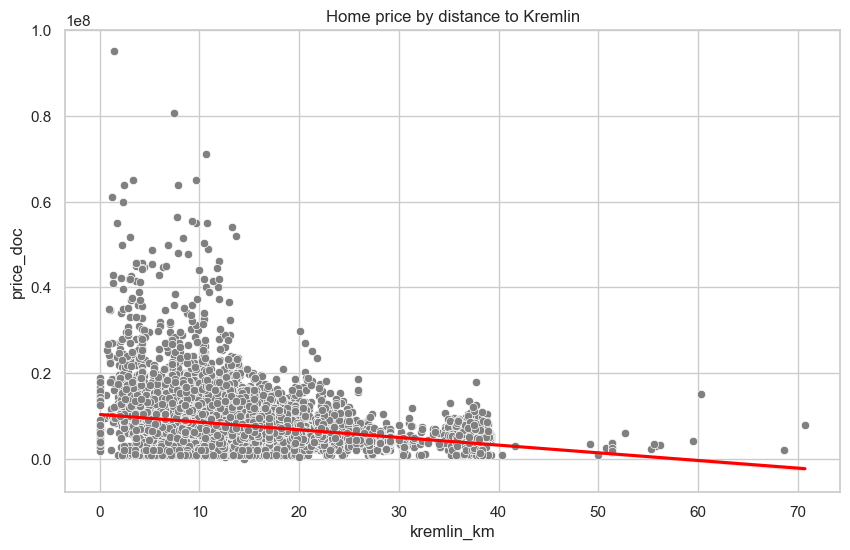

In [39]:
#relationship with distance to kremlin to price
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the scatter plot in gray
sns.scatterplot(x="kremlin_km", y="price_doc", data=dtrain, color="grey")

# Add a regression line in red
sns.regplot(x="kremlin_km", y="price_doc", data=dtrain, color="red", scatter=False, line_kws={'color': 'red'})

# Set the plot title
plt.title('Home price by distance to Kremlin')

plt.show()

In [36]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming all_data is a DataFrame containing the combined data of train and test sets

# # Number of transactions by day
# plt.figure(figsize=(12, 6))
# sns.barplot(x='timestamp', hue='dataset', data=all_data, palette=['red', 'darkgrey'])
# plt.title('Number of transactions by day')
# plt.xlabel('Timestamp')
# plt.ylabel('Count')
# plt.xticks(rotation=90)
# plt.show()

# # Sales counts by product_type and dataset
# plt.figure(figsize=(8, 6))
# sns.countplot(x='product_type', hue='dataset', data=all_data, palette=['red', 'darkgrey'])
# plt.title('Sales counts by product_type and dataset')
# plt.xlabel('Product Type')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()

# # Sales counts by home state and dataset
# plt.figure(figsize=(10, 6))
# sns.countplot(x='state', hue='dataset', data=all_data, palette=['red', 'darkgrey'])
# plt.title('Distribution of state')
# plt.xlabel('State')
# plt.ylabel('Count')
# plt.show()

# # Sales counts by material and dataset
# plt.figure(figsize=(10, 6))
# sns.countplot(x='material', hue='dataset', data=all_data, palette=['red', 'darkgrey'])
# plt.title('Distribution of material')
# plt.xlabel('Material')
# plt.ylabel('Count')
# plt.show()

NameError: name 'all_data' is not defined

<Figure size 1200x600 with 0 Axes>